In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from tqdm import tqdm

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [4]:
df = pd.read_csv(f'../data/ATVI/2021-06-01 - 2021-09-01.csv', index_col=0, parse_dates=['time'], dayfirst=True)
df.head()

,time,price
0,2021-06-01 04:00:00+00:00,97.41
1,2021-06-01 04:15:00+00:00,97.76
2,2021-06-01 04:30:00+00:00,97.99
3,2021-06-01 04:45:00+00:00,97.97
4,2021-06-01 05:00:00+00:00,97.80


In [26]:
df['time'] = pd.to_numeric(df['time'])
test_size = 74
train_df = df[:-test_size]
test_df = df[-test_size:]

In [27]:
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(df) * .95 ))

training_data_len

4586

In [28]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df)

scaled_data

array([[0.00000000e+00, 9.02692489e-01],
       [1.13507378e-04, 9.19225319e-01],
       [2.27014756e-04, 9.30089750e-01],
       ...,
       [9.99659478e-01, 2.09258385e-01],
       [9.99886493e-01, 2.03117619e-01],
       [1.00000000e+00, 2.05479452e-01]])

In [29]:
# Create the training data set
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()

# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# x_train.shape

[array([0.        , 0.00011351, 0.00022701, 0.00034052, 0.00045403,
       0.00056754, 0.00068104, 0.00079455, 0.00090806, 0.00102157,
       0.00113507, 0.00124858, 0.00136209, 0.0014756 , 0.0015891 ,
       0.00170261, 0.00181612, 0.00192963, 0.00204313, 0.00215664,
       0.00227015, 0.00238365, 0.00249716, 0.00261067, 0.00272418,
       0.00283768, 0.00295119, 0.0030647 , 0.00317821, 0.00329171,
       0.00340522, 0.00351873, 0.00363224, 0.00374574, 0.00385925,
       0.00397276, 0.00408627, 0.00419977, 0.00431328, 0.00442679,
       0.0045403 , 0.0046538 , 0.00476731, 0.00488082, 0.00499432,
       0.00510783, 0.00522134, 0.00533485, 0.00544835, 0.00556186,
       0.00567537, 0.00578888, 0.00590238, 0.00601589, 0.0061294 ,
       0.00624291, 0.00635641, 0.00646992, 0.00658343, 0.00669694])]
[0.006810442678755635]

[array([0.        , 0.00011351, 0.00022701, 0.00034052, 0.00045403,
       0.00056754, 0.00068104, 0.00079455, 0.00090806, 0.00102157,
       0.00113507, 0.00124858, 0.0

In [32]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [34]:
%%time

# Train the model

model.fit(x_train, y_train, batch_size=1, epochs=1, verbose=True)

4526/4526 [==============================] - 52s 12ms/step - loss: 3.3835e-05

In [41]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002
test_data = scaled_data[training_data_len - 74: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = df[training_data_len: :]
for i in range(74, len(test_data)):
    x_test.append(test_data[i-74:i, 0])

# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

ValueError: non-broadcastable output operand with shape (241,1) doesn't match the broadcast shape (241,2)

C:\Users\spark\AppData\Local\Temp/ipykernel_17388/1906602484.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions
C:\Users\spark\AppData\Local\Temp/ipykernel_17388/1906602484.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['time'] = pd.to_timedelta(valid['time'])
C:\Users\spark\AppData\Local\Temp/ipykernel_17388/1906602484.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

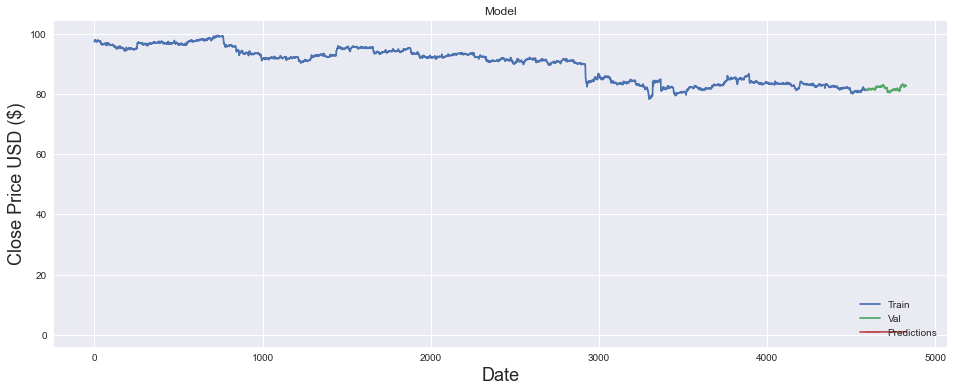

In [48]:
# Plot the data
df['time'] = pd.to_timedelta(df['time'])

train = df[:training_data_len]
valid = df[training_data_len:]
valid['Predictions'] = predictions
valid['time'] = pd.to_timedelta(valid['time'])
train['time'] = pd.to_timedelta(train['time'])
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['price'])
plt.plot(valid[['price', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()